# Sequence Modeling with Linear Regression

Yep. This may not work.
But let's see how it works.

In [1]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

## Dataset

We are going to create some 1000 timepoints of stock price data.

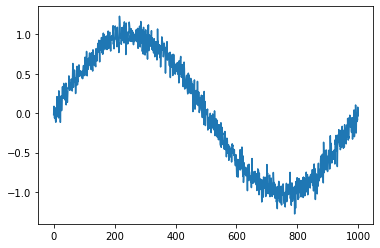

In [2]:
timesteps = 1000
X = torch.arange(0, timesteps).float()
Y = torch.sin(X * 6.28/1000) + torch.randn_like(X) * 0.1
plt.plot(X, Y)

## Data Prep

Since this is a linear regression, we need a set of features & a value.
Here's such one sample looks like.

```
features: [y0, y1, y2, y3]
value: y4
```

So, basically we give them last 4 values & it will predict the current value.

Let's create a dataset like that.

In [3]:
class StockDataset(torch.utils.data.Dataset):
    def __init__(self, n_features=4):
        self.n_features = 4
        self.n_samples = timesteps - n_features
        
        self.features_list = [Y[i: i + n_features] for i in range(self.n_samples)]
        self.labels = Y[n_features:].reshape(-1, 1)
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, i):
        return (self.features_list[i], self.labels[i], i+self.n_features)

In [4]:
dataset = StockDataset()
sample_data = next(iter(torch.utils.data.DataLoader(dataset, batch_size=32)))
sample_data[0].shape, sample_data[1].shape

(torch.Size([32, 4]), torch.Size([32, 1]))

## The Model

In [5]:
class StockModel(nn.Module):
    def __init__(self, n_features=4):
        super().__init__()
        self.n_features = n_features
        self.net = nn.Linear(in_features=n_features, out_features=10)
        self.net.weight.data.normal_(0, 0.01)
        
    def forward(self, inputs):
        return self.net(inputs)
    
_model = StockModel()
_model(sample_data[0]).shape

torch.Size([32, 10])

## Training Loop

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8, 10])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4, 10])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


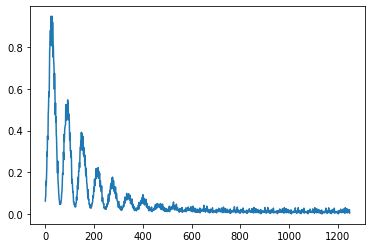

In [6]:
n_epoch = 10
lr = 0.01

dataloader = torch.utils.data.DataLoader(dataset, batch_size=8)
model = StockModel()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
calc_loss = nn.MSELoss()

loss_list = []

for epoch in tqdm(range(n_epoch)):
    for batch in dataloader:
        optimizer.zero_grad()
        
        x, y = batch[0], batch[1]        
        yhat = model(x)
        loss = calc_loss(y, yhat)
        
        with torch.no_grad():
            loss.backward()
            loss_list.append(loss.item())
            optimizer.step()
        
plt.plot(loss_list)

## Next Value Prediction

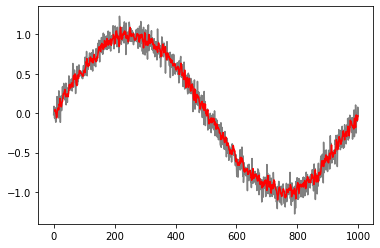

In [7]:
pred_x = []
pred_y = []
for item in dataset:
    pred_x.append(item[2])
    with torch.no_grad():
        pred_y.append(model(item[0])[0].item())
    
plt.plot(X, Y, c="gray")
plt.plot(pred_x, pred_y, c="red")

**Yep. It does a good job at predicting the next value**